In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import apogee_analysis as aah

/home/daniel/surp/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


Below, we investigate the equilibrium trends using a simple formalism. To begin, recall that the equilibrium abundance for carbon is 

$$
\dot{M}_c = y_c^{cc} \dot{M}_\star + y_c^{agb} \langle \dot{M}_\star \rangle_{agb} - (1 + \eta - r) Z_c \dot{M}_\star
$$

Where
$$
\langle \dot{M}_\star \rangle_{agb}(T) = \int_0^T \dot{M}_\star(t) f_{agb}(T - t)\ dt
$$
where $f_{agb}$ is the fraction of AGB stars with a lifetime $t$. If we make the approximation that all AGB stars have the same lifetime, $\tau_{agb} \approx 3$, we can write:
$$
\langle \dot{M}_\star \rangle_{agb}(T) =\dot{M}_\star(T - \tau_{agb}) 
$$

We can solve the first equation for the equilibrium abundace under an exponentially declining SFH: $\dot{M_g}/M_g = -1/\tau_{sfh}$, as
$$
Z_c^{eq} = \frac{y_c^{cc} + y_c^{agb} \frac{\langle \dot{M}_\star \rangle_{agb}}{\dot{M}_\star} }{1 + \eta - r - \tau_\star/\tau_{sfh}}
$$

Also, make the approximation that $y_c^{agb} = \alpha + Z \beta$ where $\alpha$ and $\beta$ are arbitrary coefficients representing the limiting low metallicity carbon AGB yield and the AGB yield dependence on metalicity. To further simplify, assume an exponentially declining SFH: $\dot{M}_\star \propto e^{-t/\tau_{sfh}}$, we can write 
$$
\frac{\langle \dot{M}_\star \rangle_{agb}}{\dot{M}_\star} = e^{\tau_{agb}/\tau_{sfh}}
$$
Using these substitutions, we can write:
$$
Z_c^{eq}(R) = \frac{y_c^{cc} + (\alpha + \beta Z(R))  e^{\frac{\tau_{agb}}{\tau_{sfh}(R)}} }{1 + \eta(R) - r - \tau_\star / \tau_{sfh}}
$$

Since we also know the equilibrium abundance of oxygen:
$$
Z_o^{eq}(R) = \frac{y_o^{cc}}{1 + \eta(R) - r - \tau_\star / \tau_{sfh}}
$$
we can make plots of \[C/O\]-\[O/H\] of the equilibrium abundance tracks, which should be an accurate approximation of the model results.

In [2]:
import vice
mw = vice.milkyway(zone_width=0.1)

In [3]:
R = np.arange(3, 11, 0.1)
eta = np.array(
    [mw.mass_loading(r) for r in R]
)



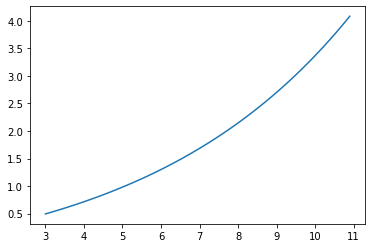

In [4]:
plt.plot(R, eta)

In [5]:
out = vice.output("output/cristallo11")

In [6]:
def get_value(name):
    return np.array([out.zones["zone%i" % (int(10*i))].history[name][-1] for i in R])

In [7]:
Z = get_value("z")
eta = get_value("eta_0")
r = get_value("r_eff")
sfr = get_value("sfr")
Mg = get_value("mgas")
Mstar = get_value("mstar")
t = get_value("time")

In [42]:
def m_star(R, t):
    T = int(100*t) - 1
    if type(R) in (list, np.array, tuple, np.ndarray):
        return [out.zones["zone%i" % int(i)].history["mstar"][T] for i in 10*R]
    else:
        i = int(10*R)
        return out.zones["zone%i" % int(i)].history["mstar"][T]

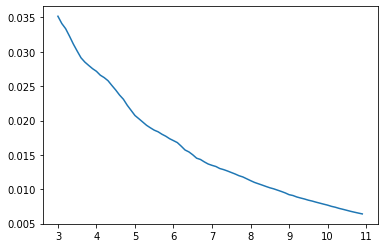

In [24]:
plt.plot(R, Z)

In [25]:
mw.evolution

<function vice.milkyway.milkyway.milkyway.default_evolution(radius, time)>

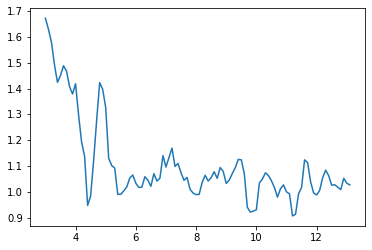

In [26]:
t = np.arange(3, 13.2, 0.1)
plt.plot(t, [m_star(R, T)[50]/m_star(R, T-0.4)[50] for T in t])

<ipython-input-109-d9e747ed35be>:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = quad(lambda t: m_star(R, t)*dn_dt(13.2 - t)/normalization, 0, 13.20)[0]


Text(0, 0.5, '$\\langle \\dot{M}_\\star \\rangle_{agb} / \\dot{M}_\\star$')

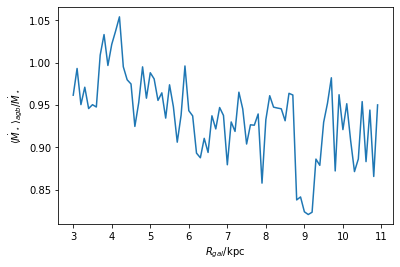

In [121]:
tau_agb = 1
plt.plot(R, [m_star_ave(r) for r in R]/np.array(m_star(R, 13.2)))
plt.xlabel("$R_{gal}$/kpc")
plt.ylabel(r"$\langle \dot{M}_\star \rangle_{agb} / \dot{M}_\star$")

In [28]:
from scipy.integrate import quad

In [29]:
quad?

In [30]:
import yields

In [31]:
y_agb = yields.y_c_agb(m_c = 0.001, alpha = -20) # function of mass, Z

In [109]:
def f(t):
    m = (t/10)**(-1/3.5)
    return m**-2.3 

def norm(f):
    return quad(f, 0, 13.2)[0]

def dn_dt(t):
    Z = 0.014
    return f(t) * y_agb((t/10)**(-1/3.5), Z)
    
def m_star_ave(R):
    normalization = norm(lambda t: dn_dt(t))
    
    result = quad(lambda t: m_star(R, t)*dn_dt(13.2 - t)/normalization, 0, 13.20)[0]
    
    return result
    

In [115]:
tau_sfh = 2.5
tau_agb = 0.8
y_o_cc = 0.015
y_c_cc = 0.002
alpha = 0.001 # this is up by a factor of 10 to reproduce the AGB abundances without cc yields.
beta = -20

denom = 1 + eta - r - Mg/(tau_sfh * Mstar)

o_eq = y_o_cc/denom
c_eq_cc = y_c_cc/denom

c_eq_agb = [alpha*(1 + beta*Z[i])*m_star_ave(R[i])/m_star(R[i], 13.2)/denom[i] for i in range(len(R))]

c_eq = c_eq_agb + c_eq_cc

o_h = aah.abundance_to_bracket(o_eq, "O")
c_h = aah.abundance_to_bracket(c_eq, "C")
c_o = c_h - o_h

<ipython-input-109-d9e747ed35be>:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = quad(lambda t: m_star(R, t)*dn_dt(13.2 - t)/normalization, 0, 13.20)[0]


Text(0, 0.5, '[C/O]')

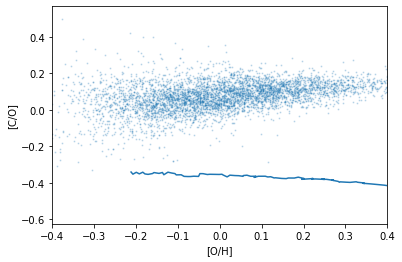

In [116]:
plt.plot(o_h, c_h - o_h)
aah.plot_apogee_cooh()
plt.xlim(-0.4, 0.4)
plt.xlabel("[O/H]")
plt.ylabel("[C/O]")

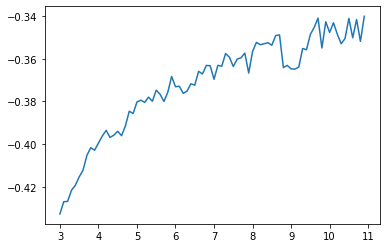

In [117]:
plt.plot(R, c_h - o_h);